In [ ]:
%load_ext autoreload
%autoreload 2
import logging
import sys
import time
from dataclasses import dataclass
from enum import Enum

from autoscript_sdb_microscope_client.structures import AdornedImage, StagePosition, ManipulatorPosition
from liftout.fibsem.sample import Sample, Lamella, AutoLiftoutState, AutoLiftoutStage

### New Sample Data Structure
Prototyping for the new sample dataclass, and filesystem structures


In [ ]:
import random
import os
from pprint import pprint

from liftout.fibsem.sample import create_experiment, load_experiment
from pathlib import Path

sample_name = "test_sample2"
sample = create_experiment(experiment_name=sample_name, path="")

for i in range(1, random.randint(6, 8)):

    lamella = Lamella(path=sample.path, number=i)
    lamella.lamella_coordinates = StagePosition(i, i, i, i, i)
    lamella.landing_coordinates = StagePosition(i, i, i, i, i)

    import random
    lamella.current_state.stage   = random.choice([stage for stage in AutoLiftoutStage]) 

    for j in range(random.randint(1, 6)):
        lamella.history.append(lamella.current_state)

    sample.positions[lamella._number] = lamella

pprint(sample)
pprint(sample.positions)

# save to file
sample.save()

# load from file
sample2 = load_experiment(sample.path)

# validation
assert sample.path == sample2.path
for i in sample.positions:
    assert sample.path[i] == sample2.path[i]
    assert sample.positions[i].lamella_coordinates == sample2.positions[i].lamella_coordinates
    assert sample.positions[i].landing_coordinates == sample2.positions[i].landing_coordinates
    assert sample.positions[i]._id == sample2.positions[i]._id
    assert sample.positions[i]._petname == sample2.positions[i]._petname
    assert sample.positions[i].current_state == sample2.positions[i].current_state
    assert sample.positions[i].history == sample2.positions[i].history
    print(f"lamella {i} passed.")

# updates to dictionarys follow reference, not sure about others

# sample.save()


### New Protocol
- Splitting the protocol into separate files. 
    - load into a single settings, dictionary
    - save protocol into individual files 
    - load protocol individually
    - possibly change to loading experiments

In [ ]:
base_path = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout"

from pprint import pprint
from liftout.utils import load_config_v2

system_fname = os.path.join(base_path, "config", "system.yaml")
calibration_fname = os.path.join(base_path, "config", "calibration.yaml")
protocol_fname = os.path.join(base_path, "protocol", "protocol.yaml")

settings = load_config_v2(
    system_fname, 
    calibration_fname, 
    protocol_fname
)

pprint(settings)


def update_protocol(settings: dict, step: str, fname: Path) -> None:

    print("step: ", step)
    pprint(settings["protocol"][step])
    print("fname: ", fname)
    print("-"*50)


# from liftout.fibsem.milling import get_milling_protocol_stages
# protocol_stages = get_milling_protocol_stages(settings, "lamella")

# pprint(protocol_stages)

for k in settings["protocol"].keys():
    update_protocol(settings, k, None)


In [ ]:
import matplotlib.pyplot as plt
from autoscript_sdb_microscope_client.structures import AdornedImage
import pandas as pd
from liftout.detection.utils import load_detection_result, plot_detection_result
from pathlib import Path


# TODO: aggregate multiple datasets together...

path = r"C:\Users\Admin\Github\autoliftout\tools\test\label\data.csv"
base = os.path.dirname(path)
df = pd.read_csv(path)
display(df)

for idx, row in df.iterrows():
    
    det_result = load_detection_result(base, row)
    fig = plot_detection_result(det_result)

    plt.show()
    plt.close()

#### CRossCorrelation Refactor

In [ ]:
from autoscript_sdb_microscope_client.structures import AdornedImage
from liftout.fibsem import calibration, acquire
from liftout.fibsem import utils as fibsem_utils
import glob
import os
import random
import matplotlib.pyplot as plt

from pprint import pprint
path = r"C:\Users\Admin\Github\autoliftout\tools\test\label"
filenames = glob.glob(os.path.join(path, "*.tif"))



In [ ]:
microscope, settings, image_settings = fibsem_utils.quick_setup()

In [ ]:
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings)


plt.imshow(eb_image.data, cmap="gray")
plt.show()



In [ ]:
eb_image.metadata.scan_settings.scan_size

from liftout import utils
from liftout.fibsem.acquire import ImageSettings, BeamType


pprint(image_settings)
image_settings = calibration.match_image_settings(ib_image, image_settings)

pprint(image_settings)




### State Testing


In [ ]:
%load_ext autoreload 
%autoreload 2
from liftout import autoliftout
from liftout.fibsem import utils as fibsem_utils
from liftout.fibsem.sample import Sample, Lamella, create_experiment

microscope, settings, image_settings = fibsem_utils.quick_setup()

print(image_settings.save_path)

sample = create_experiment("my_experiment", image_settings.save_path)

for no in range(1, 3):
    lamella = Lamella(sample.path, no)
    sample.positions[lamella._number] = lamella

from pprint import pprint 


In [ ]:
key = list(sample.positions.keys())[0]
lamella = sample.positions[key]
sample = autoliftout.end_of_stage_update(microscope, sample, lamella)

### CrossCorrelation

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage

from pprint import pprint


img1 = AdornedImage.load("../test_image.tif")
img2 = AdornedImage.load("../test_image.tif")


import matplotlib.pyplot as plt
plt.imshow(img1.data, cmap="gray")
plt.show()



xcorr = calibration.crosscorrelation(img1.data, img2.data, bp="yes", lp=128, hp=6, sigma=6)
xcorr = calibration.crosscorrelation_v2(img1.data, img2.data, bp=True, lp=128, hp=6, sigma=6)
dx, dy, xcorr = calibration.shift_from_crosscorrelation(img1, img2, lowpass=128, highpass=6, sigma=6, use_rect_mask=True)

plt.imshow(xcorr)
plt.show()

print(dx, dy)


### Edge Detection

In [ ]:
## edge detection

%load_ext autoreload
%autoreload 2

from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from pprint import pprint

img = AdornedImage.load("../test_image.tif")
centre = img.data.shape[0] // 2, img.data.shape[1] // 2
edge_px, edges_mask = detection.detect_landing_edge(img.data, centre)


fig = plt.figure(figsize=(10, 10))
plt.imshow(edges_mask, cmap="gray")
plt.plot(centre[1], centre[0], "c+", ms=50)
plt.plot(edge_px[1], edge_px[0], "r+", ms=50)
plt.show()

print("centre: ", centre)
print("closest edge: ", edge_px)

12 selected.
file: ref_landing_high_res_ib.tif


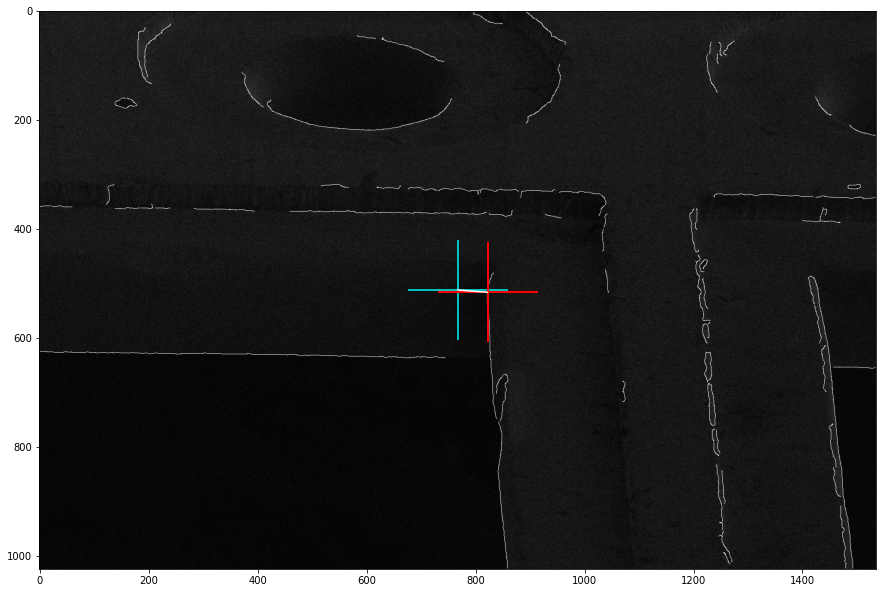

centre:  (512, 768)
closest edge:  (516, 822)


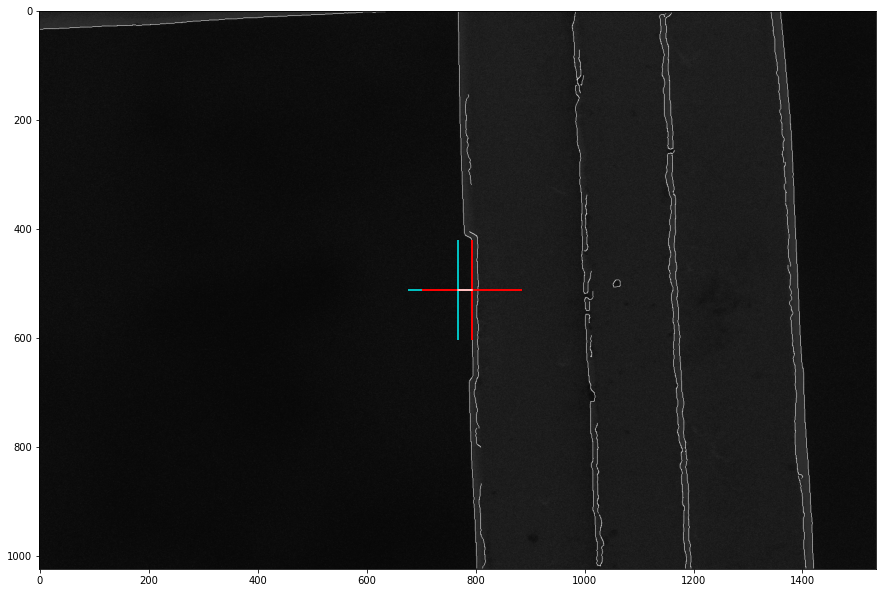

centre:  (512, 768)
closest edge:  (512, 793)


In [6]:
import glob
import random
import os

# NB: problem is bad eucentricty? ib works well, eb not so much
# snap to closest edge is pretty good

filenames = glob.glob("data/**/**/*landing*high_res_*b.tif")
fname = random.choice(filenames)

print(f"{len(filenames)} selected.")
print(f"file: {os.path.basename(fname)}")


for fname in filenames[:2]:
    img = AdornedImage.load(fname)
    centre = img.data.shape[0] // 2, img.data.shape[1] // 2
    edge_px, edges_mask = detection.detect_landing_edge(img.data, centre)

    fig = plt.figure(figsize=(15, 15))
    plt.imshow(edges_mask, cmap="gray")
    plt.plot(centre[1], centre[0], "c+", ms=100, markeredgewidth=2)
    plt.plot(edge_px[1], edge_px[0], "r+", ms=100, markeredgewidth=2)
    plt.plot((centre[1], edge_px[1]), (centre[0], edge_px[0]), "w", ms=100, markeredgewidth=2)
    plt.show()

    print("centre: ", centre)
    print("closest edge: ", edge_px)


In [ ]:
# fig.savefig('test.png',bbox_inches='tight',transparent=True, pad_inches=0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
24 selected.
file: ref_landing_low_res_ib.tif


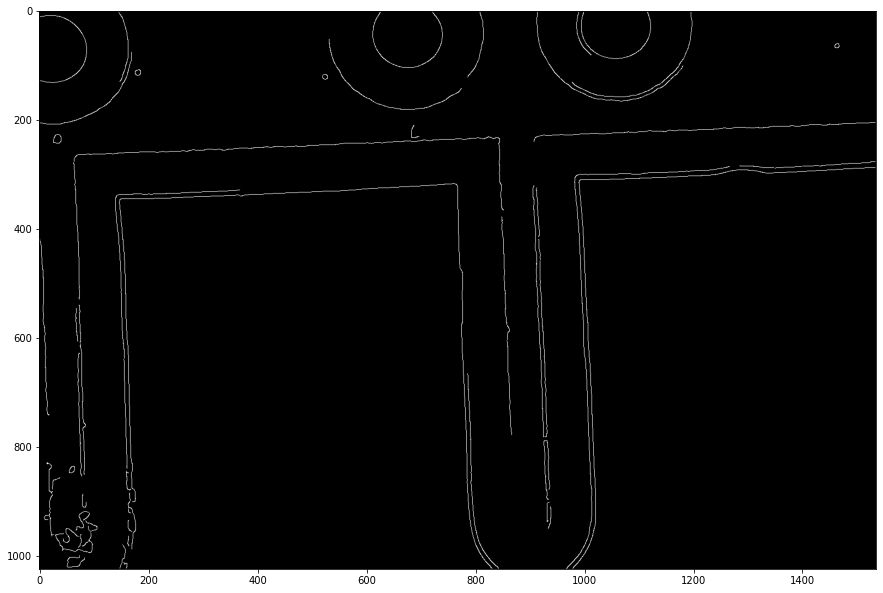

file: ref_landing_high_res_ib.tif


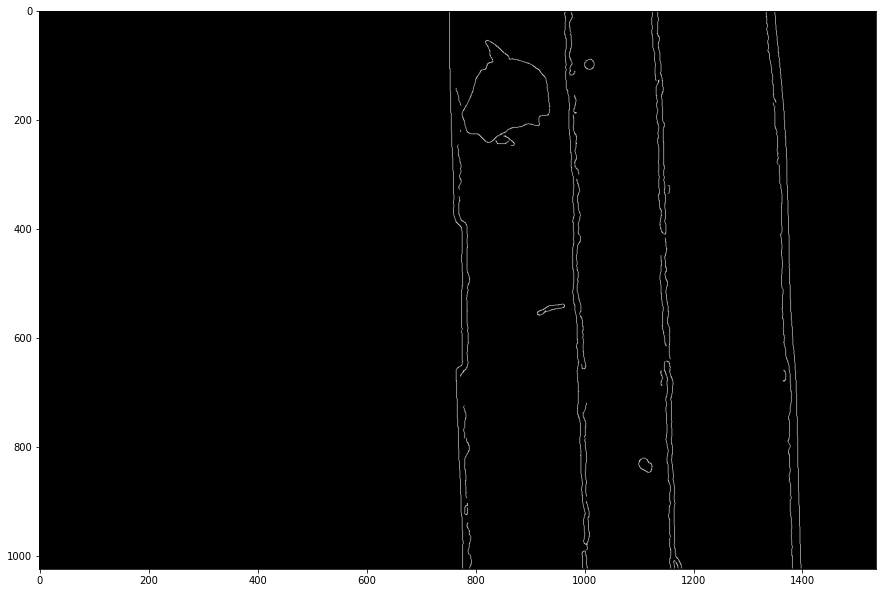

file: ref_landing_low_res_eb.tif


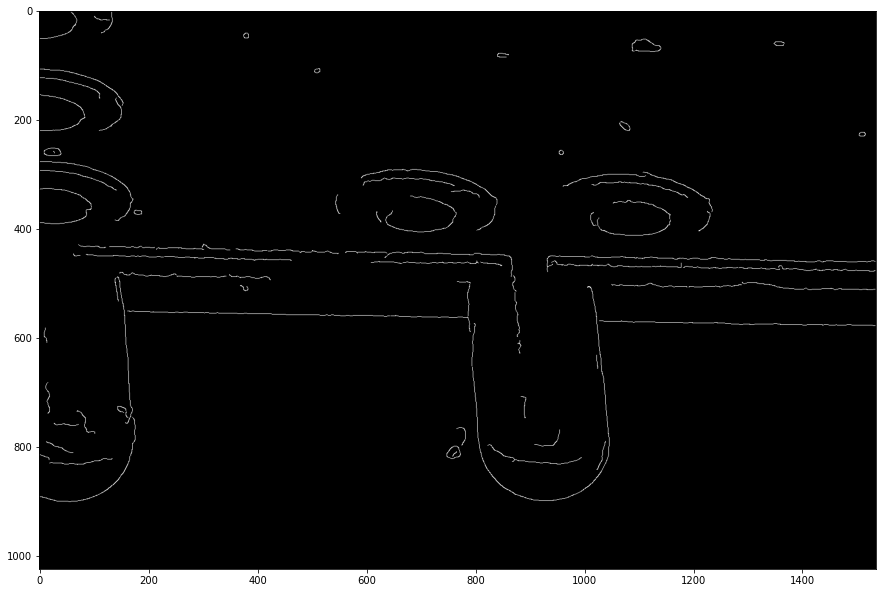

file: ref_landing_low_res_eb.tif


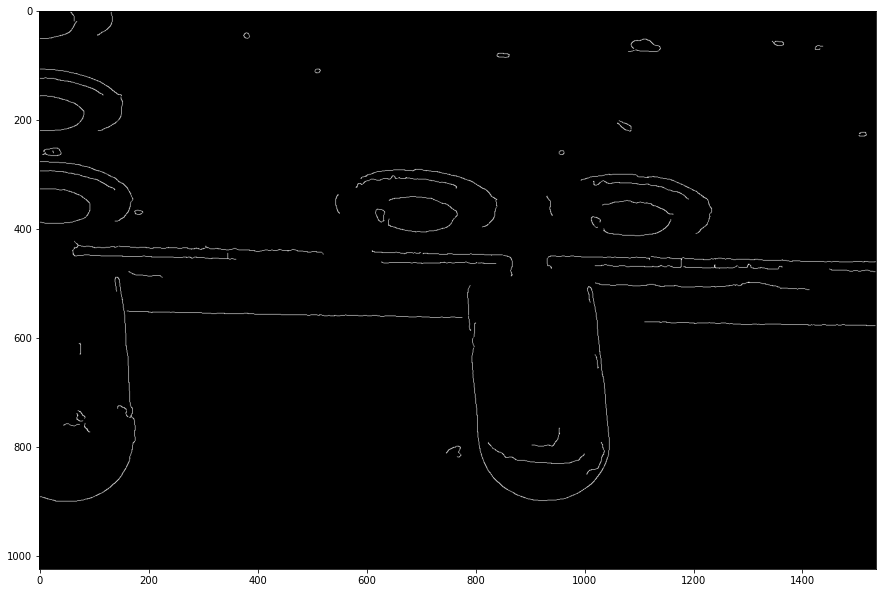

file: ref_landing_high_res_eb.tif


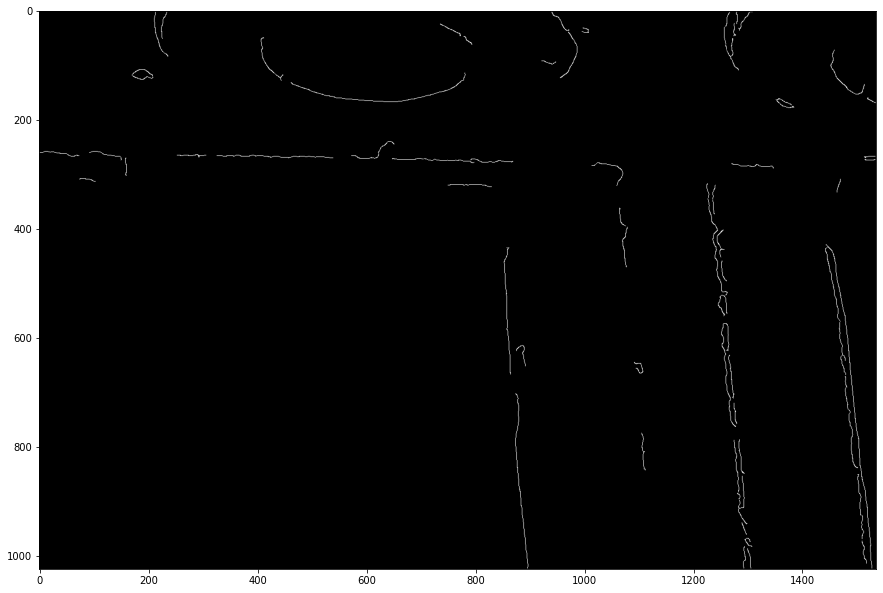

In [19]:
# Detection Model

%load_ext autoreload 
%autoreload 2

import glob
import random
import os
from pprint import pprint
from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from pprint import pprint
from liftout.detection import utils as det_utils

import numpy as np
from liftout.detection.detection import DetectionType
from liftout.detection.DetectionModel import DetectionModel
from PIL import Image

filenames = glob.glob("data/**/**/*ref*land**_*b.tif")
random.shuffle(filenames)

print(f"{len(filenames)} selected.")

weights_file = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout\model\models\boost_n05_model.pt"
model = DetectionModel(weights_file=weights_file)

N_IMAGES = 5

for fname in filenames[:N_IMAGES]:
    print(f"file: {os.path.basename(fname)}")

    adorned_img = AdornedImage.load(fname)

    det = detection.locate_shift_between_features_v2(
        model, adorned_img, shift_type=(DetectionType.LamellaEdge, DetectionType.LandingPost) 
    )

    # fig = det_utils.plot_detection_result(det)
    # plt.show()
    # plt.close()

    fig = plt.figure(figsize=(15, 15))
    plt.imshow(detection.edge_detection(adorned_img.data, sigma=3), cmap="gray")
    plt.show()
    
    # pprint(det.features)


In [17]:
filenames = glob.glob("data/**/**/*landing_*b.tif")

print(f"{len(filenames)} filenames")
pprint(filenames)

78 filenames
['data\\dm-embryo-3_20220719.104850\\3b157c1f-6ce0-4fb9-ac80-6b3063469537\\ref_landing_high_res_eb.tif',
 'data\\dm-embryo-3_20220719.104850\\3b157c1f-6ce0-4fb9-ac80-6b3063469537\\ref_landing_high_res_ib.tif',
 'data\\dm-embryo-3_20220719.104850\\3b157c1f-6ce0-4fb9-ac80-6b3063469537\\ref_landing_low_res_eb.tif',
 'data\\dm-embryo-3_20220719.104850\\3b157c1f-6ce0-4fb9-ac80-6b3063469537\\ref_landing_low_res_ib.tif',
 'data\\dm-embryo-3_20220719.104850\\552a8bea-0a8a-4f97-80fb-0fe66a5e2e6a\\landing_lamella_final_cut_highres_eb.tif',
 'data\\dm-embryo-3_20220719.104850\\552a8bea-0a8a-4f97-80fb-0fe66a5e2e6a\\landing_lamella_final_cut_highres_ib.tif',
 'data\\dm-embryo-3_20220719.104850\\552a8bea-0a8a-4f97-80fb-0fe66a5e2e6a\\landing_lamella_final_cut_lowres_eb.tif',
 'data\\dm-embryo-3_20220719.104850\\552a8bea-0a8a-4f97-80fb-0fe66a5e2e6a\\landing_lamella_final_cut_lowres_ib.tif',
 'data\\dm-embryo-3_20220719.104850\\552a8bea-0a8a-4f97-80fb-0fe66a5e2e6a\\landing_lamella_final_hi